In [57]:
import ffn 
from empyrical import alpha_beta
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import discrete_allocation
import matplotlib as pyplot
import numpy as np
import pandas as pd

## Getting stock prices and rebasing to view prices on common scales

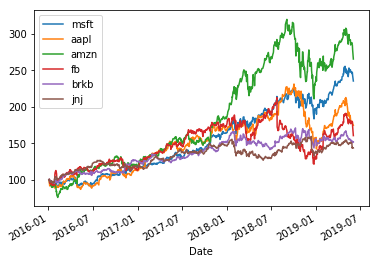

In [36]:
prices = ffn.get('msft,aapl,amzn,fb,brk-b,jnj', start='2016-01-01')
benchmark = ffn.get('spy', start='2016-01-01')
msft = ffn.get('msft', start='2016-01-01')
ax = prices.rebase().plot()

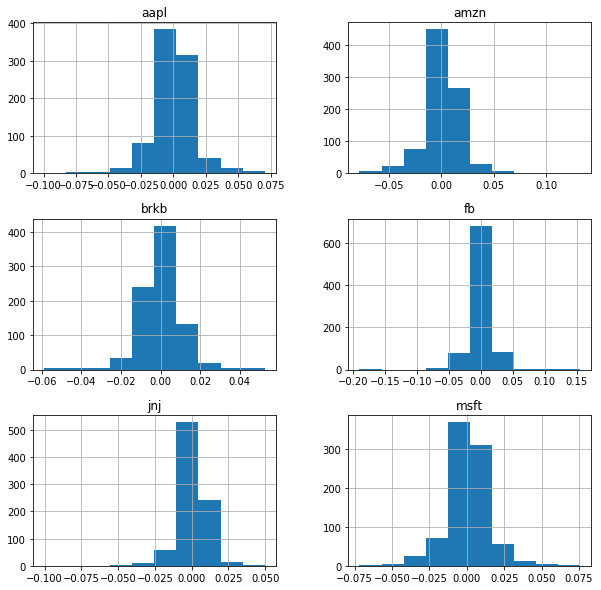

In [33]:
returns = prices.to_returns().dropna()
#ax = returns.hist(figsize=(10,10))

In [49]:
stats = prices.calc_stats()
#stats.display()

Stat                 msft        aapl        amzn        fb          brkb        jnj
-------------------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04
End                  2019-06-03  2019-06-03  2019-06-03  2019-06-03  2019-06-03  2019-06-03
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         135.55%     74.84%      165.73%     60.59%      51.86%      43.66%
Daily Sharpe         1.23        0.79        1.13        0.62        0.81        0.75
Daily Sortino        2.06        1.27        1.89        0.96        1.31        1.10
CAGR                 28.55%      17.80%      33.17%      14.89%      13.03%      11.21%
Max Drawdown         -18.23%     -38.52%     -34.10%     -42.96%     -16.09%     -18.28%
Calmar Ratio         1.57        0.46        0.97        0.35        0.81        0.61

MTD                  -3.10%

In [47]:
alpha, beta = alpha_beta(msft, benchmark)
print(beta)

0.6969549801978882


In [45]:
returns = prices.pct_change()
 
# mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
 
# portfolio weights
weights = np.asarray([0.4,0.2,0.1,0.1,0.1,0.1])
 
portfolio_return = round(np.sum(mean_daily_returns * weights) * 252,2)
portfolio_std_dev = round(np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252),2)

print("Expected annualised return: " + str(portfolio_return))
print("Volatility: " + str(portfolio_std_dev))

Expected annualized return: 0.23
Volatility: 0.18


In [56]:
# Expected returns and sample covariance
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Optimise portfolio for maximum Sharpe Ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)



{'msft': 0.46583, 'aapl': 0.0, 'amzn': 0.28355, 'fb': 0.0, 'brkb': 0.0368, 'jnj': 0.21382}
Expected annual return: 25.3%
Annual volatility: 18.9%
Sharpe Ratio: 1.23


(0.25302149406757357, 0.18918176710946344, 1.2317333621941686)

In [59]:
latest_prices = discrete_allocation.get_latest_prices(prices)
allocation, leftover = discrete_allocation.portfolio(cleaned_weights, latest_prices, total_portfolio_value=100000)
print(allocation)
print("Funds remaining: ${:.2f}".format(leftover))

2 out of 6 tickers were removed
Funds remaining: 1353.12
{'msft': 388, 'amzn': 16, 'jnj': 162, 'brkb': 19}
Funds remaining: $1353.12


In [60]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
ef.efficient_return(target_return=0.2, market_neutral=True)

{'msft': 0.8125492429069984,
 'aapl': -0.1873407209806188,
 'amzn': 0.5437365989366119,
 'fb': -0.32325181775108414,
 'brkb': -0.43000230473307854,
 'jnj': -0.4156909983788289}